# Summer of Code - Artificial Intelligence

## Week 09: Deep Learning

### Day 01: Convolutional Neural Networks

In this notebook, we will learn the theoretical foundations of **Convolutional Neural Networks (CNNs)** using PyTorch.


In [1]:
import torch
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)

# Only normalization for test
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)


In [4]:
# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(
    root="../../../datasets/data", train=True, download=True, transform=transform_train
)
trainset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../../datasets/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [8]:
int(0.9 * len(trainset))

45000

In [10]:
# Split trainset into train and validation sets
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    trainset, [train_size, val_size]
)

trainloader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

classes = trainset.classes
print(f"Classes: {classes}")
print(f"Training samples: {len(train_subset)}, Validation samples: {len(val_subset)}")

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 45000, Validation samples: 5000


In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Instantiate the model
model = SimpleCNN(num_classes=len(classes)).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                  [-1, 256]         524,544
             ReLU-14                  [

In [13]:
from torch import nn, optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [14]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total


# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total


print("Training functions defined.")

Training functions defined.


In [15]:
# Train the model
num_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, trainloader, criterion, optimizer, device
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, valloader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

print("\nTraining completed!")

Starting training...
Epoch 1/10 | Train Loss: 47.3187, Train Acc: 46.38% | Val Loss: 53.3044, Val Acc: 43.76%
Epoch 2/10 | Train Loss: 35.3965, Train Acc: 60.71% | Val Loss: 39.5772, Val Acc: 57.18%
Epoch 3/10 | Train Loss: 30.9188, Train Acc: 65.88% | Val Loss: 32.1802, Val Acc: 63.56%
Epoch 4/10 | Train Loss: 28.0147, Train Acc: 69.14% | Val Loss: 33.5774, Val Acc: 62.66%
Epoch 5/10 | Train Loss: 25.8578, Train Acc: 71.68% | Val Loss: 24.5604, Val Acc: 72.46%
Epoch 6/10 | Train Loss: 24.1669, Train Acc: 73.26% | Val Loss: 28.2576, Val Acc: 68.34%
Epoch 7/10 | Train Loss: 22.5482, Train Acc: 75.12% | Val Loss: 26.9783, Val Acc: 71.20%
Epoch 8/10 | Train Loss: 21.1930, Train Acc: 76.70% | Val Loss: 24.3666, Val Acc: 72.98%
Epoch 9/10 | Train Loss: 19.8711, Train Acc: 78.18% | Val Loss: 24.7071, Val Acc: 72.32%
Epoch 10/10 | Train Loss: 18.8700, Train Acc: 79.17% | Val Loss: 44.0687, Val Acc: 60.10%

Training completed!


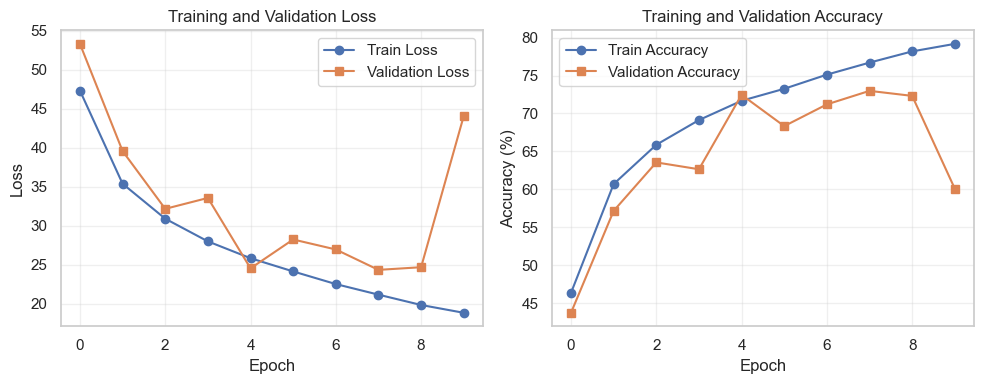


Final Validation Accuracy: 60.10%


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Plot training results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss plot
axes[0].plot(train_losses, label="Train Loss", marker="o")
axes[0].plot(val_losses, label="Validation Loss", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label="Train Accuracy", marker="o")
axes[1].plot(val_accs, label="Validation Accuracy", marker="s")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Training and Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Validation Accuracy: {val_accs[-1]:.2f}%")

In [17]:
testset = datasets.CIFAR10(
    root="../../../datasets/data", train=False, download=True, transform=None
)
testset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../../../datasets/data
    Split: Test

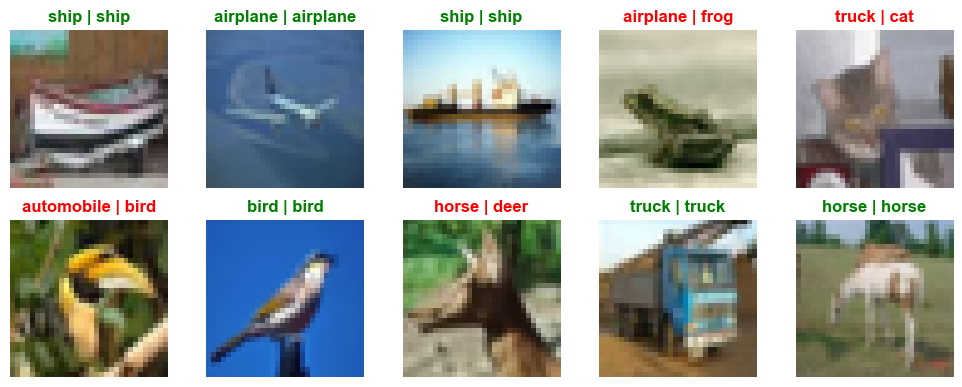

In [19]:
# Make predictions
model.eval()
indices = torch.randint(0, len(testset), (10,))

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

with torch.no_grad():
    for i, idx in enumerate(indices):
        image, label = testset[idx]
        image_tensor = transform_test(image).unsqueeze(0).to(device)

        output = model(image_tensor)
        _, predicted = output.max(1)
        predicted_label = predicted.item()

        # Display image
        axes[i].imshow(image)

        # Set title color based on correctness
        color = "green" if predicted_label == label else "red"
        axes[i].set_title(
            f"{classes[predicted_label]} | {classes[label]}",
            color=color,
            fontweight="bold",
        )
        axes[i].axis("off")

plt.tight_layout()
plt.show()

In [20]:
testset.transform = transform_test
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

test_loss, test_acc = validate(model, testloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 44.8373, Test Accuracy: 60.29%


In [21]:
torch.save(model.state_dict(), "simple_cnn_cifar10.pth")

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


# Calculate predictions and labels for all test samples
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
test_accuracy = np.mean(all_predictions == all_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 60.29%


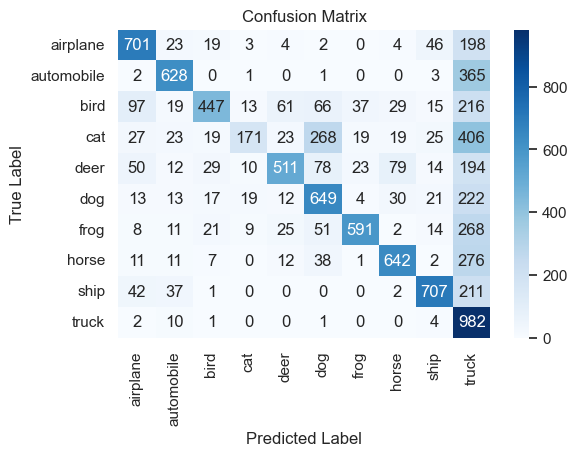

In [30]:
# Display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.title("Confusion Matrix")
plt.show()